In [33]:
import os.path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [34]:
save_folder = os.path.join(os.path.abspath(os.path.curdir), 'results')

In [39]:
def _do_test(test_name: str, first_series, second_series):
    result = scipy.stats.ttest_rel(first_series, second_series)
    print(f'{test_name}: {result.statistic} {result.pvalue}')
    
def _calculate_mean(name: str, data):
    print(f'{name} mean: {np.mean(data)}')
    
def _get_compression_coeffs(df):
    bxes_line = df['OriginalSize'].to_numpy() / df['BxesSize'].to_numpy()
    bxes_preprocessing = df['OriginalSize'].to_numpy() / df['BxesPreprocessing'].to_numpy()
    exi = df['OriginalSize'].to_numpy() / df['ExiSize'].to_numpy()
    
    return bxes_line, bxes_preprocessing, exi

class TopLevelFigure:
    experiment_name: str = None
    comp_coef_fig: plt.Figure = None
    subplots: list[int] = None
    index = 0
    handles = None
    labels = None
    
    
    def __init__(self, experiment_name: str):
        self.experiment_name = experiment_name
    
    
    def __enter__(self):
        self.comp_coef_fig = plt.figure(figsize=(15, 12))
        self.subplots = [231, 232, 233, 234, 235, 236]
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.comp_coef_fig.legend(self.handles, self.labels, loc='lower center')
        self.comp_coef_fig.savefig(os.path.join(save_folder, self.experiment_name, 'CompCoefficients.png'))
        
    
def plot_compression_graphics(df, test_name, experiment_folder_path, dto: TopLevelFigure):
    x = [x for x in range(len(df['BxesSize'].to_numpy()))]
    
    if test_name != 'AllLogs':
        bxes_line, bxes_preprocessing, exi = _get_compression_coeffs(df)
        ax = dto.comp_coef_fig.add_subplot(dto.subplots[dto.index])
        dto.index += 1

        ax.set_title(test_name)
        ax.plot(x, bxes_preprocessing, label='BxesPreprocessing')
        ax.plot(x, bxes_line, label='Bxes', linestyle='--')
        ax.plot(x, exi, label='Exi', linestyle=':')
        dto.handles, dto.labels = ax.get_legend_handles_labels()

    fig, ax = plt.subplots()
    ax.plot(x, df['OriginalSize'], label='OriginalSize')
    ax.plot(x, df['BxesToXesSize'], label='BxesToXesSize')
    ax.legend()
    
    file_size_path = os.path.join(experiment_folder_path, f'FileSize{test_name}.png')
    fig.savefig(file_size_path)
    plt.close(fig)

def print_test_results(df, test_name):
    bxes_line, bxes_preprocessing, exi = _get_compression_coeffs(df)

    print(f'TEST NAME: {test_name}')
    print('======================================')
    
    _do_test('Exi-Bxes', exi, bxes_line)
    _do_test('Exi-BxesPreprocessing', exi, bxes_preprocessing)
    _do_test('Bxes-BxesPreprocessing', bxes_line, bxes_preprocessing)
    
    _calculate_mean('Bxes', bxes_line)
    _calculate_mean('BxesPreprocessing', bxes_preprocessing)
    _calculate_mean('Exi', exi)
    
    print('======================================')
    print()

def create_sort_number(row):
    if not all_procfiler_logs_predicate(row):
        return 0
    
    if one_repeat_procfiler_logs_predicate(row):
        return 1
    
    if twenty_five_repeat_procfiler_logs_predicate(row):
        return 2
    
    if fifty_repeat_procfiler_logs_predicate(row):
        return 3
    
    if seventy_five_repeat_procfiler_logs_predicate(row):
        return 4

def plot_variants_coeff(df, test_name, experiment_folder_path):
    if not ('ValuesVariantsCoef' in df and 'AttributesVariantsCoef' in df):
        return

    x = [x for x in range(len(df['BxesSize'].to_numpy()))]
    
    sort_column = 'SortColumn'
    sort_column_values = [create_sort_number(row) for _, row in df.iterrows()]
    df.loc[:, sort_column] = sort_column_values
    df = df.sort_values(by=[sort_column])
    
    _, bxes_preprocessing, _ = _get_compression_coeffs(df)
    def scale(data):
        return (data - min(data)) / (max(data) - min(data))

    fig, ax = plt.subplots()
    ax.plot(x, scale(bxes_preprocessing), label='BxesPreprocessing')
    ax.plot(x, df['AttributesVariantsCoef'], label='AttributesVariantsCoeffs', linestyle='--')
    ax.legend(loc='upper right')
    variants_coef_path = os.path.join(experiment_folder_path, f'{test_name}_Variants.png')
    fig.savefig(variants_coef_path)
    plt.close(fig)

def test_hypothesis(experiment_name: str, test_name: str, df: pd.DataFrame, dto: TopLevelFigure):
    experiment_folder_path = os.path.join(save_folder, experiment_name)
    if not os.path.exists(experiment_folder_path):
        os.makedirs(experiment_folder_path, exist_ok=True)
        
    plot_compression_graphics(df, test_name, experiment_folder_path, dto)
    print_test_results(df, test_name)
    plot_variants_coeff(df, test_name, experiment_folder_path)

def test_hypothesis_filtered_df(experiment_name, test_name: str, df, predicate, dto: TopLevelFigure):
    filter_result = df.apply(predicate, axis=1)
    df = df[filter_result]
    print(df['Name'].unique())
    test_hypothesis(experiment_name, test_name, df, dto)

def all_procfiler_logs_predicate(row):
    return ('_1' in row['Name'] or '_25' in row['Name'] or '_50' in row['Name'] or '_75' in row['Name']) and 'BPI' not in row['Name']

def not_procfiler_log(row):
    return not all_procfiler_logs_predicate(row)

def one_repeat_procfiler_logs_predicate(row):
    return row['Name'].endswith('_1') and 'BPI' not in row['Name']

def twenty_five_repeat_procfiler_logs_predicate(row):
    return ('_25' in row['Name']) and 'BPI' not in row['Name']

def fifty_repeat_procfiler_logs_predicate(row):
    return ('_50' in row['Name']) and 'BPI' not in row['Name']

def seventy_five_repeat_procfiler_logs_predicate(row):
    return ('_75' in row['Name']) and 'BPI' not in row['Name']

def analyze_results_file(experiment_name: str, path: str):
    df = pd.read_csv(path, sep=';')
    df.head()
    
    figure = TopLevelFigure(experiment_name)
    with figure:
        test_hypothesis(experiment_name, 'AllLogs', df, figure)
        test_hypothesis_filtered_df(experiment_name, 'NotProcfilerLogs', df, not_procfiler_log, figure)
        test_hypothesis_filtered_df(experiment_name, 'ProcfilerLogs', df, all_procfiler_logs_predicate, figure)
        test_hypothesis_filtered_df(experiment_name, 'ProcfilerLogs1', df, one_repeat_procfiler_logs_predicate, figure)
        test_hypothesis_filtered_df(experiment_name, 'ProcfilerLogs25', df, twenty_five_repeat_procfiler_logs_predicate, figure)
        test_hypothesis_filtered_df(experiment_name, 'ProcfilerLogs50', df, fifty_repeat_procfiler_logs_predicate, figure)
        test_hypothesis_filtered_df(experiment_name, 'ProcfilerLogs75', df, seventy_five_repeat_procfiler_logs_predicate, figure)

TEST NAME: AllLogs
Exi-Bxes: -2.596364163440163 0.01082618740163833
Exi-BxesPreprocessing: -2.7926132251423224 0.006254805652805675
Bxes-BxesPreprocessing: -3.6934244567760683 0.00035925895222195905
Bxes mean: 53.7781774467135
BxesPreprocessing mean: 54.46259362049429
Exi mean: 47.36671226539508

['CCC19 - Log XES' 'JUnit 4.12 Software Event Log'
 'Sepsis Cases - Event Log' 'BPI Challenge 2018' 'Hospital_log'
 'BPI Challenge 2017' 'Hospital Billing - Event Log'
 'Road_Traffic_Fine_Management_Process' 'log2' 'log1'
 'Statechart Workbench and Alignments Software Event Log'
 'BPI_Challenge_2012' 'BPIC15_3' 'BPIC15_1' 'BPIC15_4' 'BPIC15_5'
 'activitylog_uci_detailed_labour' 'edited_hh104_labour'
 'edited_hh110_labour' 'edited_hh110_weekends' 'edited_hh102_weekends'
 'edited_hh104_weekends' 'edited_hh102_labour'
 'activitylog_uci_detailed_weekends' 'BPI_Challenge_2013_closed_problems'
 'BPI_Challenge_2013_incidents' 'BPI_Challenge_2013_open_problems'
 'nasa-cev-complete-splitted' 'nasa-cev-

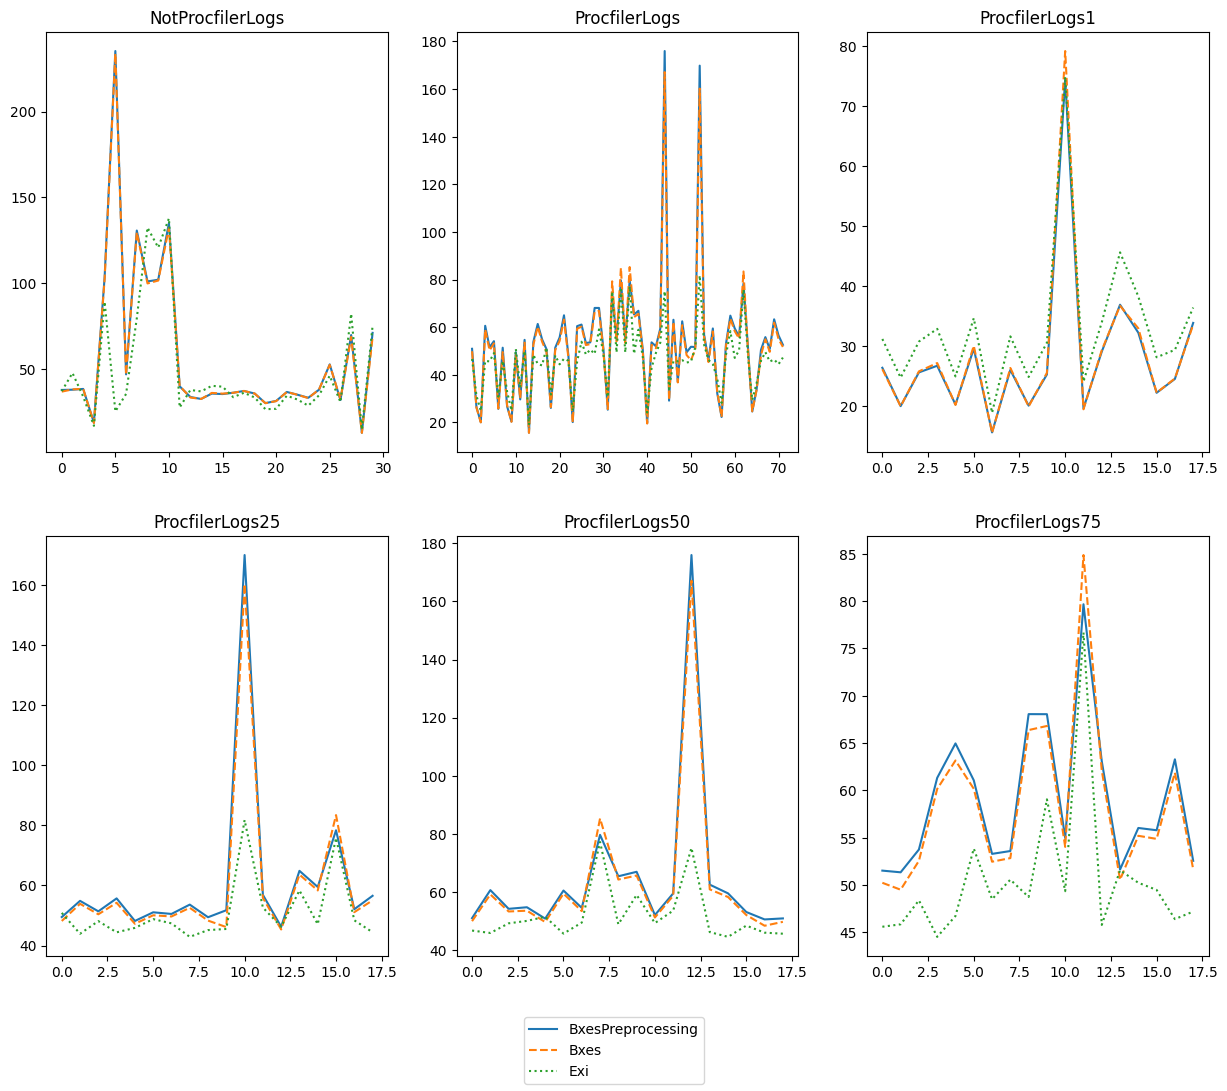

In [40]:
analyze_results_file('OldResults', 'results.csv')

TEST NAME: AllLogs
Exi-Bxes: -1.5412546634866897 0.12638218445849037
Exi-BxesPreprocessing: -1.7450665372609482 0.08401480209523475
Bxes-BxesPreprocessing: -4.559008207996465 1.4451699485235988e-05
Bxes mean: 51.179215192218805
BxesPreprocessing mean: 51.774749039354084
Exi mean: 47.36671226539508

['CCC19 - Log XES' 'JUnit 4.12 Software Event Log'
 'Sepsis Cases - Event Log' 'BPI Challenge 2018' 'Hospital_log'
 'BPI Challenge 2017' 'Hospital Billing - Event Log'
 'Road_Traffic_Fine_Management_Process' 'log2' 'log1'
 'Statechart Workbench and Alignments Software Event Log'
 'BPI_Challenge_2012' 'BPIC15_3' 'BPIC15_1' 'BPIC15_4' 'BPIC15_5'
 'activitylog_uci_detailed_labour' 'edited_hh104_labour'
 'edited_hh110_labour' 'edited_hh110_weekends' 'edited_hh102_weekends'
 'edited_hh104_weekends' 'edited_hh102_labour'
 'activitylog_uci_detailed_weekends' 'BPI_Challenge_2013_closed_problems'
 'BPI_Challenge_2013_incidents' 'BPI_Challenge_2013_open_problems'
 'nasa-cev-complete-splitted' 'nasa-ce

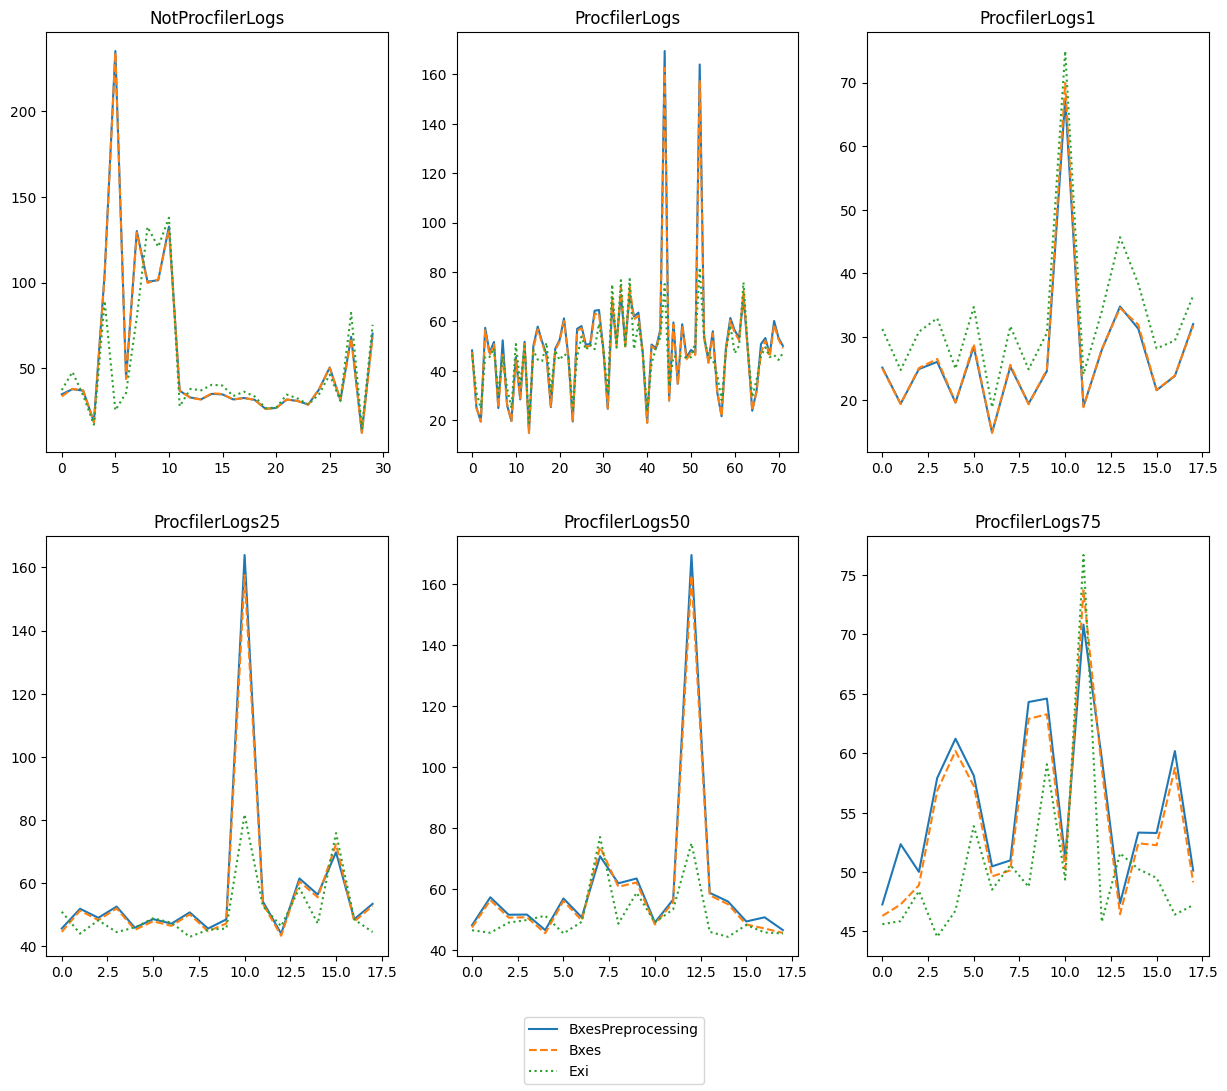

In [41]:
analyze_results_file('NewResultsNoLifecycle', 'results_no_lifecycle.csv')

TEST NAME: AllLogs
Exi-Bxes: -1.5049051027477156 0.1355005369329433
Exi-BxesPreprocessing: -1.709993939644089 0.09036811502672946
Bxes-BxesPreprocessing: -4.577676192185515 1.354926003332512e-05
Bxes mean: 51.31961881628168
BxesPreprocessing mean: 51.92256760138383
Exi mean: 47.56087795563652

['CCC19 - Log XES' 'JUnit 4.12 Software Event Log'
 'Sepsis Cases - Event Log' 'BPI Challenge 2018' 'Hospital_log'
 'BPI Challenge 2017' 'Hospital Billing - Event Log'
 'Road_Traffic_Fine_Management_Process' 'log2' 'log1'
 'Statechart Workbench and Alignments Software Event Log' 'BPIC15_3'
 'BPIC15_1' 'BPIC15_4' 'BPIC15_5' 'activitylog_uci_detailed_labour'
 'edited_hh104_labour' 'edited_hh110_labour' 'edited_hh110_weekends'
 'edited_hh102_weekends' 'edited_hh104_weekends' 'edited_hh102_labour'
 'activitylog_uci_detailed_weekends' 'BPI_Challenge_2013_closed_problems'
 'BPI_Challenge_2013_incidents' 'BPI_Challenge_2013_open_problems'
 'nasa-cev-complete-splitted' 'nasa-cev-1-10-single-trace'
 'nasa

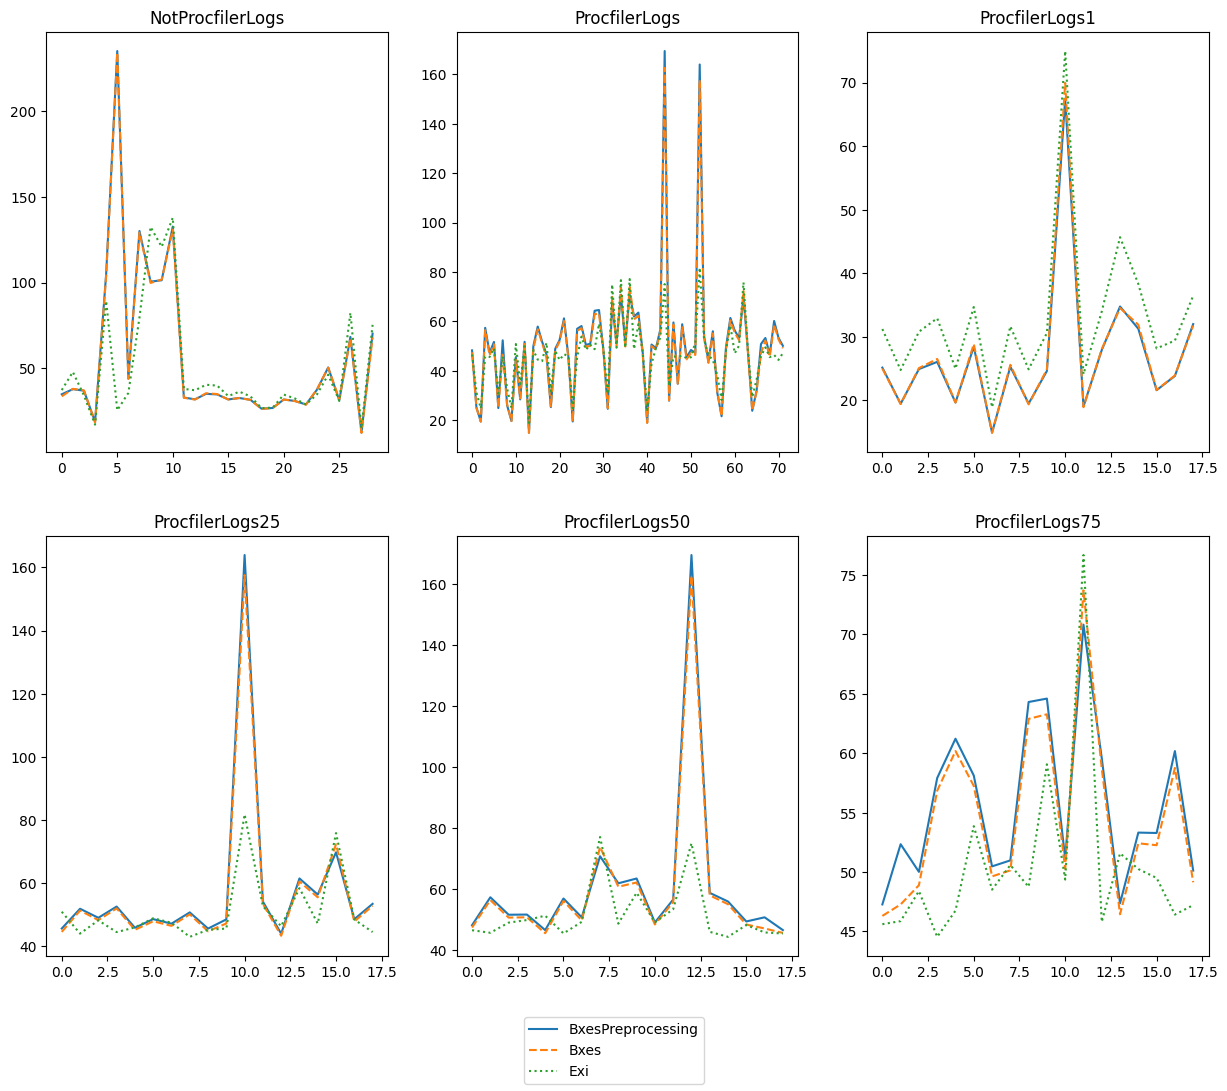

In [42]:
analyze_results_file('NewResultsNoLifecycleVariantsCoeffs', 'results_with_coeffs.csv')